In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
modSourceDir= '/data/eolson/results/MEOPAR/SS36runs/GrahamRuns/2018ES_LF/'
modver='2018ES_LF'
Chl_N=1.8 # Chl:N ratio
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2015,6,30) #dt.datetime(2019,6,30)

In [3]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [4]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [5]:
if os.path.isfile('matched_'+modver+datestr+'.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
    df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='long'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'.pkl','wb') as f:
        pickle.dump(data,f)

/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015.csv ['ADM:SCIENTIST', 'Chlorophyll:Extracted', 'Cruise', 'Cryptophytes', 'Cyanobacteria', 'Diatoms-1', 'Diatoms-2', 'Dictyo', 'Dinoflagellates-1', 'FIL:START TIME YYYY/MM/DD HH:MM:SS', 'File Name', 'Flag:Chlorophyll:Extracted', 'Flag:Nitrate_plus_Nitrite', 'Flag:Oxygen:Dissolved', 'Flag:Phosphate', 'Flag:Salinity:Bottle', 'Flag:Silicate', 'Fluorescence:URU:Seapoint', 'Haptophytes', 'LOC:EVENT_NUMBER', 'LOC:STATION', 'LOC:WATER DEPTH', 'Lat', 'Lon', 'Nitrate_plus_Nitrite', 'Number_of_bin_records', 'Oxygen:Dissolved', 'Oxygen:Dissolved:CTD', 'PAR', 'Phaeo-Pigment:Extracted', 'Phosphate', 'Prasinophytes', 'Pressure', 'Raphido', 'Salinity', 'Salinity:Bottle', 'Sample_Number', 'Silicate', 'TchlA (ug/L)', 'Temperature', 'Temperature:Draw', 'Transmissivity', 'Zone', 'pH:SBE:Nominal']
/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016.csv ['ADM:PROJECT', 'ADM:SCIENTIST', 'Bottle:Firing_Sequence', 'Bottle_Number', 'Chlorophyll:Ext

In [6]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

(0, 8)

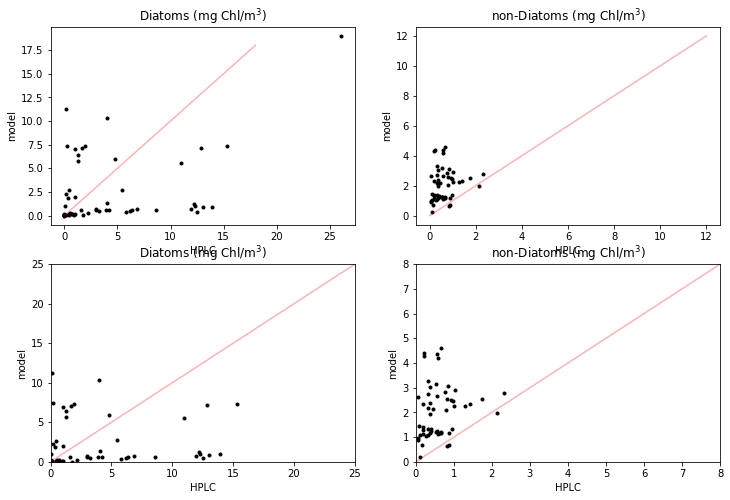

In [7]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax=ax.flatten()
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms (mg Chl/m$^3$)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,18),(0,18),'r-',alpha=.3)

ax[1].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((0,12),(0,12),'r-',alpha=.3)

ax[2].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[2].set_title('Diatoms (mg Chl/m$^3$)')
ax[2].set_xlabel('HPLC')
ax[2].set_ylabel('model')
ax[2].plot((0,25),(0,25),'r-',alpha=.3)
ax[2].set_xlim((0,25))
ax[2].set_ylim((0,25))

ax[3].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[3].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[3].set_xlabel('HPLC')
ax[3].set_ylabel('model')
ax[3].plot((0,12),(0,12),'r-',alpha=.3)
ax[3].set_xlim((0,8))
ax[3].set_ylim((0,8))

In [8]:
def logt(x):
    return np.log10(x+.001)

(-3.1, 2)

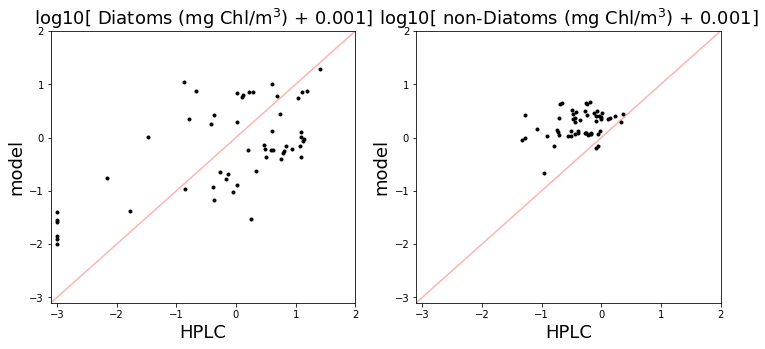

In [9]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(Chl_N*data['mod_diatoms']),'k.')
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[0].set_xlabel('HPLC',fontsize=18)
ax[0].set_ylabel('model',fontsize=18)
ax[0].set_xlim(-3.1,2)
ax[0].set_ylim(-3.1,2)
ax[0].plot((-6,3),(-6,3),'r-',alpha=.3)

ax[1].plot(logt(data['other']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('log10[ non-Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[1].set_xlabel('HPLC',fontsize=18)
ax[1].set_ylabel('model',fontsize=18)
ax[1].plot((-6,3),(-6,3),'r-',alpha=.3)
ax[1].set_xlim(-3.1,2)
ax[1].set_ylim(-3.1,2)

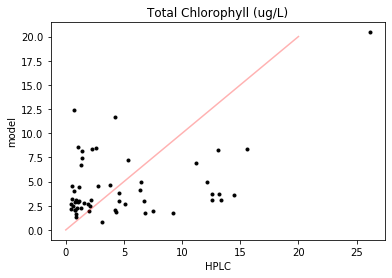

In [10]:
plt.plot(data['TchlA (ug/L)'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
plt.title('Total Chlorophyll (ug/L)')
plt.xlabel('HPLC')
plt.ylabel('model')
plt.plot((0,20),(0,20),'r-',alpha=.3)

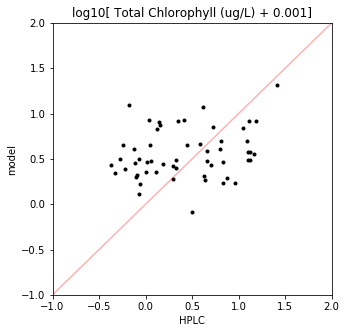

In [11]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);

In [12]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

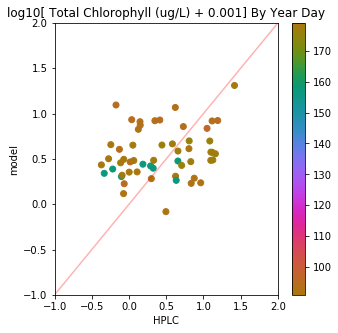

In [13]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);
fig.colorbar(m)

In [14]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

## Multiple Linear Regression

#### Diatoms

In [15]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [16]:
m

array([  0.15362011,   0.53705251, -18.59835986,  -4.1147894 ,
        -0.69707046,   2.47382085,  -9.47613134,  -3.22807949,
         6.92805154,   1.12486821])

In [17]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.15362010517970096
Diatoms-2 0.5370525136344207
Cyanobacteria -18.598359863668296
Cryptophytes -4.11478940137139
Prasinophytes -0.697070462543518
Haptophytes 2.4738208531562136
Dictyochophytes -9.47613134008586
Dinoflagellates -3.2280794949396108
Raphidophytes 6.928051542084849
ones 1.1248682091533673


In [18]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [19]:
clist=('Diatoms-1','Diatoms-2','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.14154549311372153
Diatoms-2 0.09174958765481278
Cryptophytes -5.156844002272221
Raphidophytes 5.284391528044782
ones 1.3974490683403271


In [20]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [21]:
clist=('Diatoms-1','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.14499654733629624
Cryptophytes -5.134087754268163
Raphidophytes 5.1740744108946215
ones 1.412721385811937


#### flagellates

In [22]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [23]:
m

array([ 3.62349585e-03, -2.87070360e-01,  9.78042634e+00,  2.29461273e-02,
        1.46210925e+00, -6.68310185e-01, -4.10156957e+00,  4.22687229e-02,
       -4.45418943e-01,  6.54249207e-01])

In [24]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.0036234958534809222
Diatoms-2 -0.28707035984171997
Cyanobacteria 9.78042633700488
Cryptophytes 0.022946127347855002
Prasinophytes 1.4621092506367768
Haptophytes -0.6683101854728772
Dictyochophytes -4.101569568838664
Dinoflagellates 0.04226872287429033
Raphidophytes -0.44541894277273747
ones 0.6542492069408701


In [25]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             data.loc[ii]['Dinoflagellates'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [26]:
clist=('Diatoms-1','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 -0.003492440405774762
Cyanobacteria 9.856053648274441
Cryptophytes 0.3371327589433806
Prasinophytes 1.0889578576309311
Haptophytes -0.5804871449829264
Dictyochophytes -6.499559024603098
Dinoflagellates -0.46551523992896404
ones 0.6021349158066318


In [27]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [28]:
clist=('Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Cyanobacteria 10.009595279342664
Cryptophytes 0.04098760671663093
Prasinophytes 1.3933813294354769
Haptophytes -0.49778588249938593
Dictyochophytes -6.81550667434942
ones 0.5557648273130189


#### M. rubrum

In [29]:
ii=(~pd.isnull(data['mod_ciliates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_ciliates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [30]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.014522618987242433
Diatoms-2 -0.07637852658674282
Cyanobacteria -1.5530543193895352
Cryptophytes 0.28936233755418134
Prasinophytes -0.3474422162497295
Haptophytes -0.022588197484232884
Dictyochophytes 1.234743624724585
Dinoflagellates 0.2426084184025224
Raphidophytes 0.07913791603449481
ones 0.39038901660459696


Diatoms:
- Cryptophytes 0.38
- Diatoms-1 0.16
- Raphidophytes 0.09

Flagellates:
- Cyanobacteria 0.9248939785743201
- Cryptophytes 0.592769155988474
- Prasinophytes 0.18975008147644779
- Haptophytes 0.2794204846195845
- Dictyochophytes 0.058845777018170356

M. rubrum:
- Cyanobacteria 0.2710109702166438

None:
- Diatoms-2
- Dinoflagellates

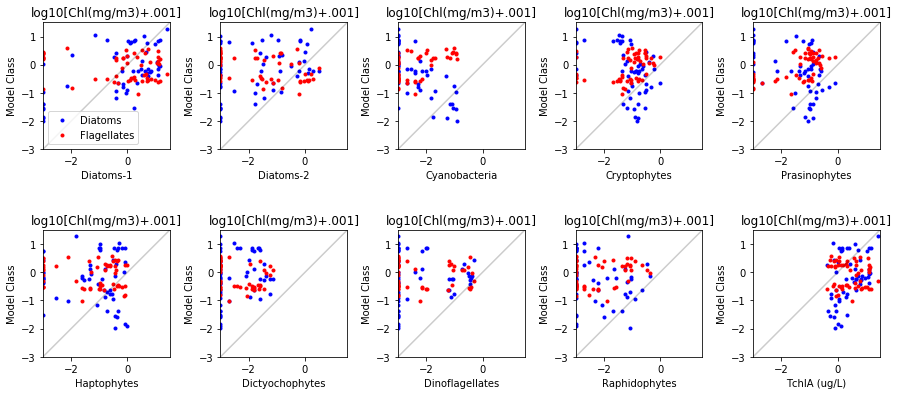

In [31]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','TchlA (ug/L)')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',color='blue',label='Diatoms')
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


(-3, 1.5)

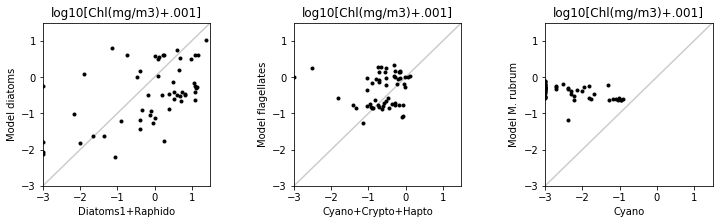

In [32]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']),logt(data['mod_diatoms']),'k.')
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cyanobacteria']+data['Cryptophytes']+data['Haptophytes']),logt(data['mod_flagellates']),'k.')
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Cyano+Crypto+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))


ax[2].plot(logt(data['Cyanobacteria']),logt(data['mod_ciliates']),'k.')
ax[2].set_ylabel('Model M. rubrum')
ax[2].set_xlabel('Cyano')
ax[2].set_title('log10[Chl(mg/m3)+.001]')
ax[2].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2].set_xlim((-3,1.5))
ax[2].set_ylim((-3,1.5))

In [33]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CCPH']=data['Cyanobacteria']+data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]

### Variance-Covariance Matrix

In [34]:
dfVars.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,27.253244,1.017793,-0.054003,-0.090195,-0.056810,-0.595294,-0.009301,0.101353,-0.012529,28.271038,-0.796302,27.553557,7.829763,-0.649576,0.758015,7.938202
Diatoms-2,1.017793,0.375903,-0.003801,-0.007400,-0.000883,-0.052940,0.002094,0.025765,-0.005659,1.393697,-0.065024,1.350779,0.336257,-0.202425,-0.000499,0.133334
Cyanobacteria,-0.054003,-0.003801,0.001068,-0.000165,0.000120,0.002049,-0.000087,-0.000554,0.000121,-0.057804,0.003072,-0.055256,-0.037976,0.018765,-0.004537,-0.023748
Cryptophytes,-0.090195,-0.007400,-0.000165,0.033249,0.020320,-0.000702,0.000517,0.009071,0.010192,-0.097595,0.052701,-0.025124,-0.235887,0.044722,0.010323,-0.180842
Prasinophytes,-0.056810,-0.000883,0.000120,0.020320,0.017550,-0.001524,0.000441,0.002407,0.005430,-0.057692,0.036466,-0.012948,-0.153675,0.043626,0.000777,-0.109272
Haptophytes,-0.595294,-0.052940,0.002049,-0.000702,-0.001524,0.064185,-0.000259,-0.007239,0.001180,-0.648234,0.064008,-0.590506,0.069721,-0.021288,-0.019602,0.028830
Dictyochophytes,-0.009301,0.002094,-0.000087,0.000517,0.000441,-0.000259,0.000271,0.000369,0.000452,-0.007207,0.000613,-0.005505,-0.004314,-0.003510,0.000543,-0.007281
Dinoflagellates,0.101353,0.025765,-0.000554,0.009071,0.002407,-0.007239,0.000369,0.016930,0.003439,0.127118,0.003686,0.151519,-0.092742,-0.011174,0.012871,-0.091044
Raphidophytes,-0.012529,-0.005659,0.000121,0.010192,0.005430,0.001180,0.000452,0.003439,0.006417,-0.018188,0.016923,0.009039,-0.037691,0.010040,0.005398,-0.022253
DD,28.271038,1.393697,-0.057804,-0.097595,-0.057692,-0.648234,-0.007207,0.127118,-0.018188,29.664734,-0.861326,28.904336,8.166021,-0.852001,0.757516,8.071536


### Correlation Coefficient Matrix

In [35]:
dfVars.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.317989,-0.316480,-0.094751,-0.082145,-0.450098,-0.108225,0.149213,-0.029960,0.994288,-0.385889,0.990838,0.400933,-0.117178,0.519488,0.444234
Diatoms-2,0.317989,1.000000,-0.189676,-0.066193,-0.010867,-0.340824,0.207454,0.322972,-0.115224,0.417359,-0.268305,0.413600,0.146611,-0.310923,-0.002909,0.063533
Cyanobacteria,-0.316480,-0.189676,1.000000,-0.027711,0.027686,0.247459,-0.161128,-0.130171,0.046081,-0.324695,0.237790,-0.317360,-0.310580,0.540658,-0.496644,-0.212253
Cryptophytes,-0.094751,-0.066193,-0.027711,1.000000,0.841199,-0.015201,0.172372,0.382325,0.697735,-0.098270,0.731185,-0.025866,-0.345818,0.230974,0.202540,-0.289741
Prasinophytes,-0.082145,-0.010867,0.027686,0.841199,1.000000,-0.045399,0.202345,0.139653,0.511728,-0.079958,0.696377,-0.018349,-0.310100,0.310129,0.020982,-0.240976
Haptophytes,-0.450098,-0.340824,0.247459,-0.015201,-0.045399,1.000000,-0.062038,-0.219589,0.058141,-0.469782,0.639164,-0.437565,0.073567,-0.079133,-0.276819,0.033246
Dictyochophytes,-0.108225,0.207454,-0.161128,0.172372,0.202345,-0.062038,1.000000,0.172214,0.342729,-0.080380,0.094243,-0.062769,-0.070041,-0.200801,0.118061,-0.129198
Dinoflagellates,0.149213,0.322972,-0.130171,0.382325,0.139653,-0.219589,0.172214,1.000000,0.329988,0.179376,0.071665,0.218614,-0.190539,-0.080874,0.353918,-0.204423
Raphidophytes,-0.029960,-0.115224,0.046081,0.697735,0.511728,0.058141,0.342729,0.329988,1.000000,-0.041687,0.534440,0.021183,-0.125778,0.118030,0.241087,-0.081157
DD,0.994288,0.417359,-0.324695,-0.098270,-0.079958,-0.469782,-0.080380,0.179376,-0.041687,1.000000,-0.400075,0.996269,0.400795,-0.147315,0.497598,0.432947


### Cov matrix with log transformed values:

In [36]:
dflog=pd.DataFrame()
for el in ['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','CCPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']:
    dflog[el]=logt(data[el])
dflog.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.976083,0.535597,-0.660378,-0.168929,0.026764,-0.812395,0.119630,0.614425,-0.010371,-0.281929,0.539512,0.717853,-0.148855,0.157444,0.108396
Diatoms-2,0.535597,1.519169,-0.198741,0.023919,-0.139647,-0.145591,0.077954,0.437530,-0.046834,-0.127809,0.200914,0.373632,-0.258709,0.004872,-0.022009
Cyanobacteria,-0.660378,-0.198741,0.521108,0.164164,0.258076,0.212388,-0.127833,-0.074596,0.155304,0.095186,-0.146920,-0.452075,0.184749,-0.069971,-0.064728
Cryptophytes,-0.168929,0.023919,0.164164,0.661769,0.392504,0.015855,0.007877,0.369475,0.185385,0.202037,-0.008188,-0.306478,0.120815,-0.008416,-0.089408
Prasinophytes,0.026764,-0.139647,0.258076,0.392504,0.824198,-0.098904,-0.091532,0.255784,0.229482,0.163989,0.104734,-0.386974,0.250364,-0.008323,-0.068721
Haptophytes,-0.812395,-0.145591,0.212388,0.015855,-0.098904,1.092189,0.097924,-0.163706,0.033368,0.253804,-0.254894,-0.076754,-0.049419,-0.044352,0.013942
Dictyochophytes,0.119630,0.077954,-0.127833,0.007877,-0.091532,0.097924,0.427019,0.171508,0.056185,0.020216,0.000988,0.149039,-0.099587,0.013270,-0.009610
Dinoflagellates,0.614425,0.437530,-0.074596,0.369475,0.255784,-0.163706,0.171508,1.016234,0.212540,0.051399,0.228567,0.055450,-0.022470,0.065792,-0.070045
Raphidophytes,-0.010371,-0.046834,0.155304,0.185385,0.229482,0.033368,0.056185,0.212540,0.738868,0.051764,0.041536,-0.173360,0.118092,-0.001728,-0.044851
CCPH,-0.281929,-0.127809,0.095186,0.202037,0.163989,0.253804,0.020216,0.051399,0.051764,0.178400,-0.064155,-0.138162,0.055391,-0.006072,-0.023081


### Corr Coeff matrix with log transformed values:

In [37]:
dflog.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.309124,-0.650768,-0.147723,0.020972,-0.552988,0.130231,0.433580,-0.008583,-0.474831,0.785792,0.598524,-0.235928,0.594838,0.283614
Diatoms-2,0.309124,1.000000,-0.223368,0.023855,-0.124800,-0.113027,0.096786,0.352134,-0.044205,-0.245506,0.333745,0.355295,-0.467658,0.020995,-0.065677
Cyanobacteria,-0.650768,-0.223368,1.000000,0.279552,0.393793,0.281525,-0.270992,-0.102507,0.250285,0.312186,-0.416701,-0.733998,0.570215,-0.514787,-0.329794
Cryptophytes,-0.147723,0.023855,0.279552,1.000000,0.531465,0.018650,0.014817,0.450541,0.265117,0.588004,-0.020608,-0.441565,0.330893,-0.054945,-0.404241
Prasinophytes,0.020972,-0.124800,0.393793,0.531465,1.000000,-0.104243,-0.154289,0.279486,0.294069,0.427664,0.236199,-0.499591,0.614435,-0.048692,-0.278414
Haptophytes,-0.552988,-0.113027,0.281525,0.018650,-0.104243,1.000000,0.143389,-0.155388,0.037145,0.574978,-0.499367,-0.086080,-0.105357,-0.225390,0.049067
Dictyochophytes,0.130231,0.096786,-0.270992,0.014817,-0.154289,0.143389,1.000000,0.260355,0.100026,0.073245,0.003095,0.267316,-0.339547,0.107849,-0.054088
Dinoflagellates,0.433580,0.352134,-0.102507,0.450541,0.279486,-0.155388,0.260355,1.000000,0.245280,0.120715,0.464223,0.064469,-0.049662,0.346618,-0.255564
Raphidophytes,-0.008583,-0.044205,0.250285,0.265117,0.294069,0.037145,0.100026,0.245280,1.000000,0.142576,0.098934,-0.236381,0.306094,-0.010675,-0.191914
CCPH,-0.474831,-0.245506,0.312186,0.588004,0.427664,0.574978,0.073245,0.120715,0.142576,1.000000,-0.310989,-0.383390,0.292186,-0.076349,-0.200992


### New groups Model-Obs Comparison:

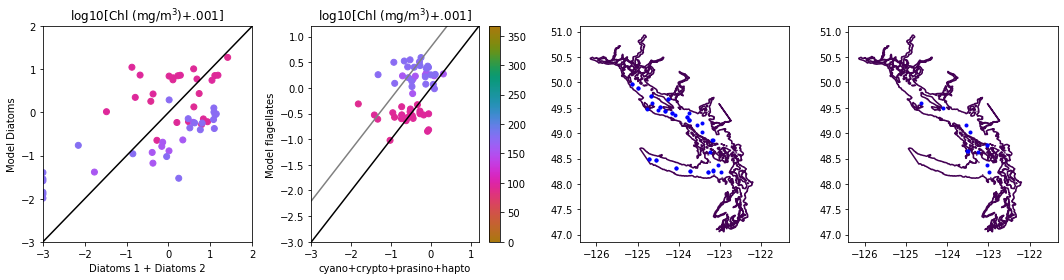

In [68]:
fig,ax=plt.subplots(1,4,figsize=(15,4))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CCPH']),logt(data['mod_flagellates_chl']),
          c=data['yd'],cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('cyano+crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
thresh=.8
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#ax[2].contour(navlon,navlat,tmask[0,:,:],levels=[0.5,])
#ihi=logt(data['mod_diatoms_chl'])>(logt(data['DD'])+thresh)
#ax[2].plot(data.loc[(data.DD>=0)&(~ihi),['Lon']],data.loc[(data.DD>=0)&(~ihi),['Lat']],'b.')
#ax[3].contour(navlon,navlat,tmask[0,:,:],levels=[0.5,])
#ax[3].plot(data.loc[(data.DD>=0)&ihi,['Lon']],data.loc[(data.DD>=0)&ihi,['Lat']],'b.')
ax[2].contour(navlon,navlat,tmask[0,:,:],levels=[0.5,])
ihi=logt(data['mod_flagellates_chl'])>(logt(data['CCPH'])+thresh)
ax[2].plot(data.loc[(data.CCPH>=0)&(~ihi),['Lon']],data.loc[(data.CCPH>=0)&(~ihi),['Lat']],'b.')
ax[3].contour(navlon,navlat,tmask[0,:,:],levels=[0.5,])
ax[3].plot(data.loc[(data.CCPH>=0)&ihi,['Lon']],data.loc[(data.CCPH>=0)&ihi,['Lat']],'b.')

### Diatom fraction

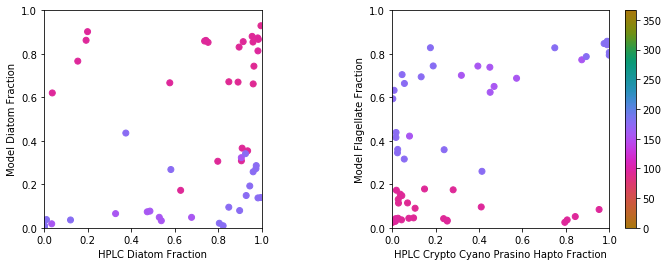

In [45]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
diatFracMod=data['mod_diatoms']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
diatFracObs=data['DD']/data['TchlA (ug/L)']
m=ax[0].scatter(diatFracObs,diatFracMod,
          c=data['yd'],cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlabel('HPLC Diatom Fraction')
ax[0].set_ylabel('Model Diatom Fraction')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
flFracMod=data['mod_flagellates']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
CCPHFracObs=data['CCPH']/data['TchlA (ug/L)']
m=ax[1].scatter(CCPHFracObs,flFracMod,
          c=data['yd'],cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_xlabel('HPLC Crypto Cyano Prasino Hapto Fraction')
ax[1].set_ylabel('Model Flagellate Fraction')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.colorbar(m)

In [40]:
#Reminder:
np.random.seed(42)
df = pd.DataFrame(np.random.randn(1000, 4),columns=['a', 'b', 'c','d'])
df['a+b+c']=.2*df['a']+.3*df['b']+.45*df['c']

In [41]:
df.cov()

,a,b,c,d,a+b+c
a,0.929140,0.007946,-0.037053,-0.022301,0.171538
b,0.007946,1.023910,-0.032939,0.004689,0.293940
c,-0.037053,-0.032939,1.012188,0.034186,0.438192
d,-0.022301,0.004689,0.034186,1.013977,0.012330
a+b+c,0.171538,0.293940,0.438192,0.012330,0.319676


In [42]:
df.corr()

,a,b,c,d,a+b+c
a,1.000000,0.008146,-0.038208,-0.022976,0.314749
b,0.008146,1.000000,-0.032355,0.004602,0.513774
c,-0.038208,-0.032355,1.000000,0.033745,0.770334
d,-0.022976,0.004602,0.033745,1.000000,0.021657
a+b+c,0.314749,0.513774,0.770334,0.021657,1.000000


In [43]:
A=np.vstack([df['a'],df['b'],df['c'],df['d'],np.ones(np.shape(df['a']))]).T
b=df['a+b+c']
m=np.linalg.lstsq(A,b,rcond=None)[0]
print(m)

[ 2.00000000e-01  3.00000000e-01  4.50000000e-01  1.52655666e-16
 -1.04083409e-16]
